############################## Patrick L. Mthisi (Patrickmthisi@hotmail.com)##########################
# Project description and objectives:
The dataset consists of Dell's stock prices. For more information  about the data used in this project, refer to:

https://www.kaggle.com/datasets/zongaobian/microsoft-stock-data-and-key-affiliated-companies?select=DELL_daily_data.csv.


This comprehensive project aims to tease out various Holt-Winters configurations to identify which ones yield superior prediction performance for Dell's daily stock prices. This notebook serves as an extensive demonstration of an ETS-based time series forecasting approach for Dell's stock prices, encompassing time series analysis, visualization, and performance evaluation using RMSE.

The following essential time series forecasting concepts are explored in this project:
1. Holt-Winters Modeling: The ETS (Error, Trend, Seasonality) model is utilized for forecasting. This process involves determining the optimal ETS parameters for level, trend, dampening, and seasonal effects, achieved through an automated search of historical data to identify the best parameters.
2. Rolling Forecast: 
    - Once the model is fitted, a rolling forecast method is applied, allowing for predictions to be made one step ahead. The model is updated iteratively using actual values.
3. Model Evaluation:
    - The predicted values are compared to the actual values from the validation set.
    - The Root Mean Squared Error (RMSE) serves as the metric for assessing the model's performance.
    - Final predictions alongside the actual validation data are visualized.    
4. Next Steps: The project also highlights potential future enhancements, such as exploring additional time series forecasting models. These may include classical approaches like SARIMA as well as more advanced methodologies involving CNNs and LSTMs.

# Load libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from warnings import catch_warnings, filterwarnings
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as stats

from pandas.plotting import autocorrelation_plot
import json
import pickle
import ast

# User-defined functions
def measure_rmse(actual, predicted):
    if len(actual) != len(predicted):
        raise ValueError("Actual and predicted arrays must have the same length.")
    return sqrt(mean_squared_error(actual, predicted))

def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

def normalize(train, test):
    scaler = MinMaxScaler(feature_range=(0,1))
    train = train.reshape(-1, 1)
    test = test.reshape(-1, 1)
    trasformed_train  = scaler.fit_transform(train)
    transformed_test = scaler.transform(test)
    return trasformed_train, transformed_test, scaler.data_min_, scaler.data_max_

def standardize(train, test):
    scaler = StandardScaler()
    train = train.reshape(-1, 1)
    test = test.reshape(-1, 1)
    trasformed_train  = scaler.fit_transform(train)
    transformed_test = scaler.transform(test)
    return trasformed_train, transformed_test, scaler.mean_, sqrt(scaler.var_)

def inverse_normalize(data, data_min, data_max):
    data =  np.array(data)
    return data_min + data * (data_max - data_min)

def inverse_standardize(data, data_mean, data_std):
    data =  np.array(data)
    return data_mean + data * data_std

def transform_data(data, transform=None):
    if not isinstance(data, np.ndarray):
        data = np.array(data).reshape(-1, 1)
    if transform == 'normalize':
        scaler = MinMaxScaler(feature_range=(0, 1))
        data = scaler.fit_transform(data)
        return data, scaler.data_min_, scaler.data_max_
    elif transform == 'standardize':
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
        return data, scaler.mean_, scaler.scale_  
    elif transform is None:
        return data
    else:
        raise ValueError(f"Unknown transform type: {transform}. Use 'normalize', 'standardize', or None.")

# Load Data

In [2]:
filename = 'DELL_daily_data.csv'
series = pd.read_csv(filename, usecols=['Date','Adj Close'], header=0, parse_dates=True, index_col=0)
print(series.shape)
split_point = len(series) - 20
dataset, validation = series[:split_point], series[split_point:]
# del series
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
data_path = 'dell_stock_price'
os.makedirs(f'{data_path}', exist_ok=True)
dataset.to_csv(f'{data_path}/dataset.csv', header=False)
validation.to_csv(f'{data_path}/validation.csv', header=False)

(2042, 1)
Dataset 2022, Validation 20


In [3]:
class timeseries_eda(object):
    def __init__(self, series):
        self.series = series
        
    def line_plot(self, window):
        self.window = window
        
        rolmean = self.series.rolling(window=self.window).mean()
        rolstd = self.series.rolling(window=self.window).std()

        plt.figure(figsize=(12, 7))
        plt.plot(self.series, color='blue', label='Dell Adj. Close', lw=.5)
        plt.plot(rolmean, color='black', label='Rolling Mean')
        plt.plot(rolstd, color='green', label='Rolling Std')
        plt.title('Dell Adj. Close Price')
        plt.xlabel('Date')
        plt.ylabel('Dell Adj. Close')
        plt.legend()
        plt.show()
        

    def view_yearly(self, start, end):
        self.start = start
        self.end = end
        series = self.series[start:end]
        groups = series.groupby(pd.Grouper(freq='YE'))
        year_data = {}
        for name, group in groups:
            year_data[name.year] = group.values
        years = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in year_data.items()]))
        fig, axes = plt.subplots(nrows=len(years.columns), ncols=1, figsize=(12, 7), sharex=True)
        for i, (year, data) in enumerate(years.items()):
            axes[i].plot(data, color='blue', label=f'{year}', lw=1.0)
            axes[i].set_title(f"Year: {year}")
            axes[i].legend(loc="upper right")

        plt.tight_layout()
        plt.show()
        
    def auto_correlation_plot(self):
        plt.figure(figsize=(12, 7))
        autocorrelation_plot(series, color='red')
        plt.show()

In [4]:
series = pd.read_csv(f'{data_path}/dataset.csv', header=None, index_col=0, parse_dates=True).squeeze("columns")
tsa = timeseries_eda(series=series)

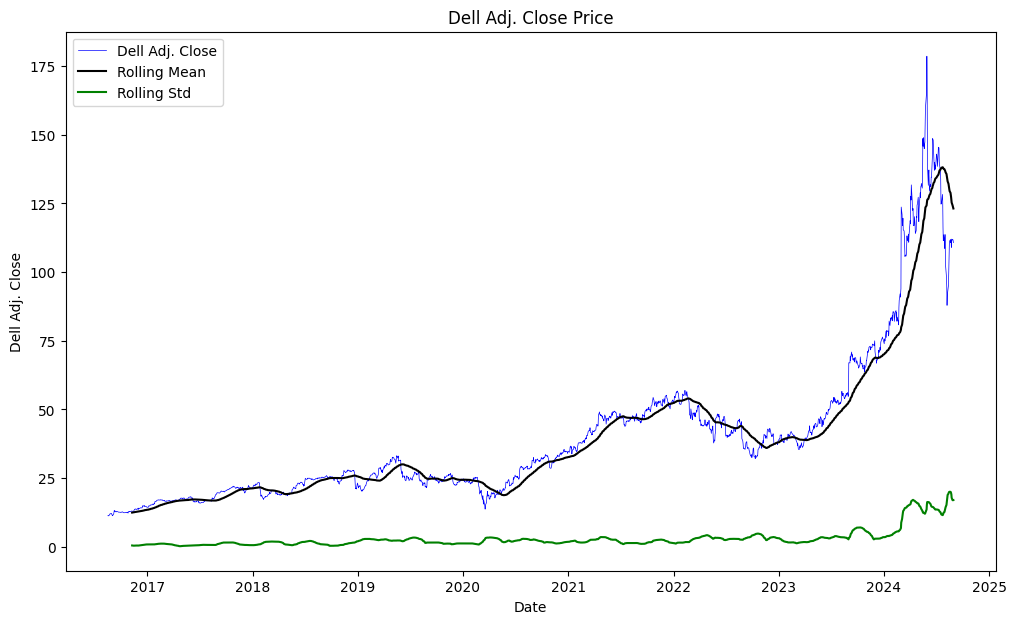

In [5]:
window = 60
tsa.line_plot(window=window)

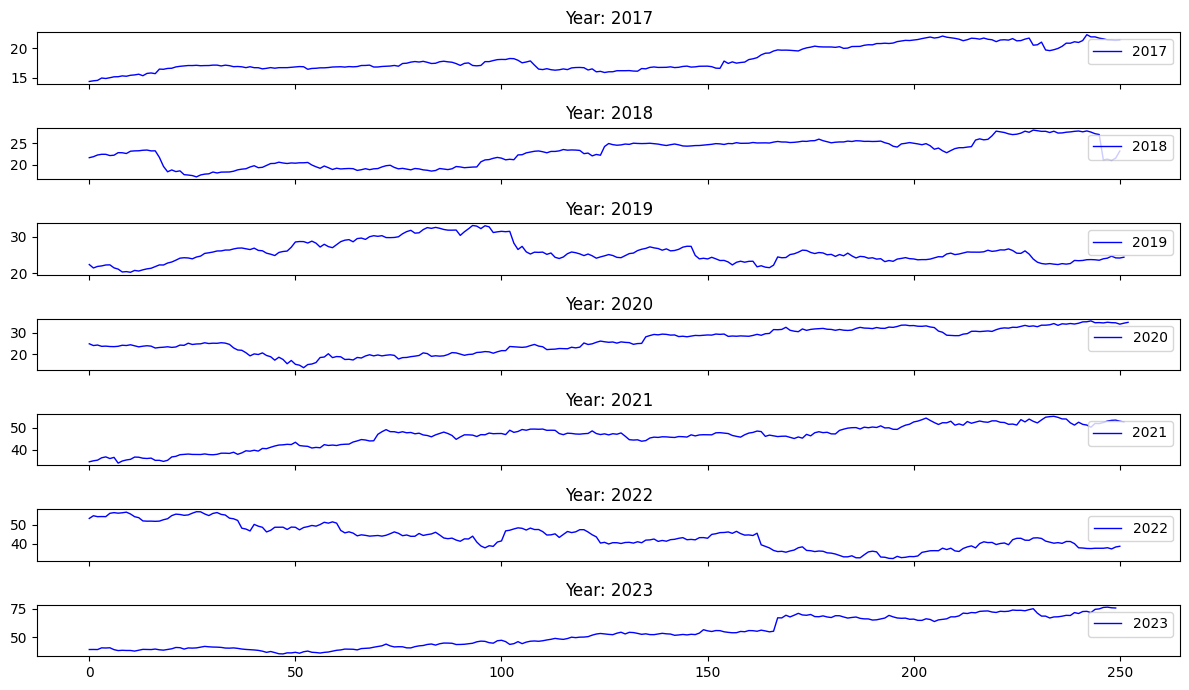

In [6]:
tsa.view_yearly(start='2017', end='2023')

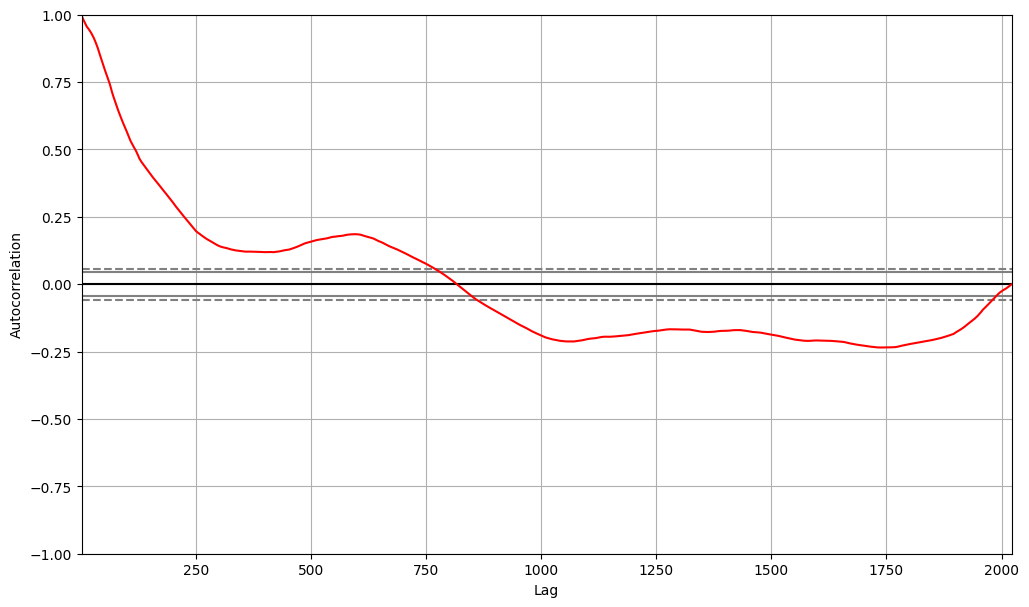

In [7]:
tsa.auto_correlation_plot()

# Naive Forecast Model

In [8]:
class search_naive_forecast_params(object):
    def __init__(self, data, n_test, cfg_list, verbose):
        self.data = data
        self.n_test = n_test
        self.cfg_list = cfg_list
        self.verbose = verbose

    def simple_forecast(self, history, config):
        n, offset, avg_type = config
        if avg_type == 'persist':
            return history[-n]
        values = []
        if offset == 1:
            values = history[-n:]
        else:
            if n * offset > len(history):
                raise Exception('Config beyond end of data: %d %d' % (n, offset))
            for i in range(1, n + 1):
                ix = i * offset
                values.append(history[-ix])
        if len(values) < 2:
            raise Exception('Cannot calculate average')
        if avg_type == 'mean':
            return np.mean(values)
        return np.median(values)

    def walk_forward_validation(self, data, n_test, cfg):
        predictions = []
        train, test = train_test_split(data, n_test)
        history = list(train)
        for i in range(len(test)):
            yhat = self.simple_forecast(history, cfg)
            predictions.append(yhat)
            history.append(test[i])
        error = measure_rmse(test, predictions)
        return error

    def score_model(self, data, n_test, cfg, debug=False):
        verbose = self.verbose
        result = None
        key = str(cfg)
        if debug:
            result = self.walk_forward_validation(data, n_test, cfg)
        else:
            try:
                with catch_warnings():
                    filterwarnings('ignore')
                    result = self.walk_forward_validation(data, n_test, cfg)
            except:
                result = None
        if verbose:
            if result is not None:
                print(f'> Model[{key}] RMSE: {result:.3f}')
        return (key, result)

    def grid_search(self, parallel=True):
        data = self.data
        n_test = self.n_test
        cfg_list = self.cfg_list
        print("Running grid search on model configurations...\n")
        scores = None
        if parallel:
            executor = Parallel(n_jobs=cpu_count()-1, backend='multiprocessing')
            tasks = (delayed(self.score_model)(data, n_test, cfg) for cfg in cfg_list)
            scores = executor(tasks)
        else:
            scores = [self.score_model(data, n_test, cfg) for cfg in cfg_list]
        scores = [r for r in scores if r[1] is not None]
        scores.sort(key=lambda tup: tup[1])
        return scores

def simple_configs(max_length, offsets=[1]):
    configs = []
    for i in range(1, max_length + 1):
        for o in offsets:
            for t in ['persist', 'mean', 'median']:
                cfg = (i, o, t)
                configs.append(cfg)
    print(f'Total number of configurations: {len(configs)}')
    return configs

if __name__ == '__main__':
    # Load dataset
    series = pd.read_csv(f'{data_path}/dataset.csv', header=None, index_col=0, parse_dates=True).squeeze('columns')
    data = series.values
    n_test = 252

    max_length = len(data) - n_test
    cfg_list = simple_configs(max_length)

    naive_models = search_naive_forecast_params(data, n_test, cfg_list, verbose=False)
    scores = naive_models.grid_search()

    top_configs = 5
    print(f'\nTop {top_configs} best configurations:')
    for cfg, error in scores[:top_configs]:
        print(f'Model[{cfg}]: RMSE {error:.3f}')

Total number of configurations: 5310
Running grid search on model configurations...


Top 5 best configurations:
Model[(1, 1, 'persist')]: RMSE 4.169
Model[(2, 1, 'mean')]: RMSE 4.894
Model[(2, 1, 'median')]: RMSE 4.894
Model[(3, 1, 'mean')]: RMSE 5.508
Model[(3, 1, 'median')]: RMSE 5.837


# ETS Forecast Model

In [9]:
class search_ets_forecast_params:
    def __init__(self, data, n_test, cfg_list, transforms, verbose):
        self.data = data
        self.n_test = n_test
        self.cfg_list = cfg_list
        self.transforms = transforms
        self.verbose = verbose
    
    def ets_forecast(self, history, config):
        t,d,s,p,b,r = config
        history = np.array(history)
        model = ExponentialSmoothing(history, trend=t, damped_trend=d, seasonal=s, seasonal_periods=p, use_boxcox=b)
        model_fit = model.fit(optimized=True, remove_bias=r)
        yhat = model_fit.predict(len(history), len(history))
        return yhat[0]
        
    def walk_forward_validation(self, data, n_test, cfg, transform=None):
        predictions = []
        train, test = train_test_split(data, n_test)
        if transform == 'normalize':
            train, test, min_, max_ = normalize(train, test)
        elif transform == 'standardize':
            train, test, mean_, std_ = standardize(train, test)
        history = [x for x in train]
        for i in range(len(test)):
            yhat = self.ets_forecast(history, cfg)
            predictions.append(yhat)
            history.append(test[i])
        if transform == 'normalize':
            predictions = inverse_normalize(predictions, min_, max_)
            test = inverse_normalize(test, min_, max_)
        elif transform == 'standardize':
            predictions = inverse_standardize(predictions, mean_, std_)
            test = inverse_standardize(test, mean_, std_)
        error = measure_rmse(test, predictions)
        return error
    
    def score_model(self, data, n_test, cfg, transform=None, debug=False):
        verbose = self.verbose
        result = None
        key = str(cfg) + f'_{transform}'
        if debug:
            result = self.walk_forward_validation(data, n_test, cfg, transform)
        else:
            try:
                with catch_warnings():
                    filterwarnings('ignore', module='statsmodels')
                    result = self.walk_forward_validation(data, n_test, cfg, transform)
            except Exception as e:
                if verbose:
                    print(f"Model[{key}] failed due to: {e}")
                result = None
        if verbose:
            if result is not None:
                print(f'> Model[{key}] RMSE: {result:.3f}')
        return (key, result)

    def grid_search(self, parallel=True):
        data = self.data
        n_test = self.n_test
        cfg_list = self.cfg_list
        transforms = self.transforms
        print("Running grid search on model configurations...\n")
        scores = None
        if parallel:
            executor = Parallel(n_jobs=cpu_count()-1, backend='multiprocessing')
            tasks = (delayed(self.score_model)(data, n_test, cfg, transform) for cfg in cfg_list for transform in transforms)
            scores = executor(tasks)
        else:
            scores = [score_model(data, n_test, cfg, transform) for cfg in cfg_list for transform in transforms]
        scores = [r for r in scores if r[1] is not None]
        scores.sort(key=lambda tup: tup[1])
        return scores

def ets_configs(seasonal=[None]):
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    configs=[]
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            configs.append(cfg)
    print(f'Total number of configurations: {len(configs)}')
    return configs

if __name__ == '__main__':
    series = pd.read_csv(f'{data_path}/dataset.csv', header=None, index_col=0, parse_dates=True)
    data = series.values
    n_test = 252

    cfg_list = ets_configs()
    transforms = [None, 'normalize', 'standardize']

    ets_models = search_ets_forecast_params(data, n_test, cfg_list, transforms, verbose=False)
    scores = ets_models.grid_search()

    top_configs = 5
    print(f'\nTop {top_configs} best configurations:')
    for cfg, error in scores[:top_configs]:
        print(f'Model[{cfg}]: RMSE {error:.3f}')

Total number of configurations: 72
Running grid search on model configurations...


Top 5 best configurations:
Model[[None, False, None, None, True, True]_None]: RMSE 4.168
Model[[None, False, None, None, True, False]_None]: RMSE 4.169
Model[['add', True, None, None, True, True]_None]: RMSE 4.171
Model[['add', True, None, None, True, False]_None]: RMSE 4.172
Model[['mul', True, None, None, True, False]_None]: RMSE 4.173


# Fit best model and save to file

In [10]:
best_cfg, _ = scores[0]
input_string = best_cfg
parts = input_string.split('_')
config_part, transform_part = ast.literal_eval(parts[0]), ast.literal_eval(parts[1])

series = pd.read_csv(f'{data_path}/dataset.csv', header=0, parse_dates=True, index_col=0)
X = series.values.astype('float32')
X = transform_data(X, transform=transform_part)

t,d,s,p,b,r = config_part
model = ExponentialSmoothing(X, trend=t, damped_trend=d, seasonal=s, seasonal_periods=p, use_boxcox=b)
model_fit = model.fit(optimized=True, remove_bias=r)

with open(f'{data_path}/dell_stock_price_forecasting_model.pkl', 'wb') as file:
    pickle.dump(model_fit, file)
print('Model saved successfully using pickle.')


with open(f'{data_path}/config_part.json', 'w') as file:
    json.dump(config_part, file)
print('Configuration saved successfully.')

Model saved successfully using pickle.
Configuration saved successfully.


# Load and Predict

In [11]:
with open(f'{data_path}/dell_stock_price_forecasting_model.pkl', 'rb') as file:
    loaded_model_fit = pickle.load(file)
print('Model loaded successfully using pickle.')

yhat = loaded_model_fit.forecast()[0]
print(f'Prediction for the next time step: {yhat:.3f}')

Model loaded successfully using pickle.
Prediction for the next time step: 110.789


# Model Validation

Configuration loaded successfully: [None, False, None, None, True, True]
>Predicted=110.789, Expected=115.540
>Predicted=115.592, Expected=110.770
>Predicted=110.819, Expected=109.060
>Predicted=109.108, Expected=107.160
>Predicted=107.207, Expected=102.000
>Predicted=102.045, Expected=105.890
>Predicted=105.937, Expected=106.640
>Predicted=106.687, Expected=108.800
>Predicted=108.848, Expected=112.150
>Predicted=112.200, Expected=114.300
>Predicted=114.351, Expected=115.400
>Predicted=115.451, Expected=116.820
>Predicted=116.872, Expected=115.990
>Predicted=116.041, Expected=117.770
>Predicted=117.822, Expected=117.500
>Predicted=117.552, Expected=117.570
>Predicted=117.622, Expected=117.310
>Predicted=117.362, Expected=120.170
>Predicted=120.223, Expected=126.490
>Predicted=126.547, Expected=120.220
RMSE: 3.233


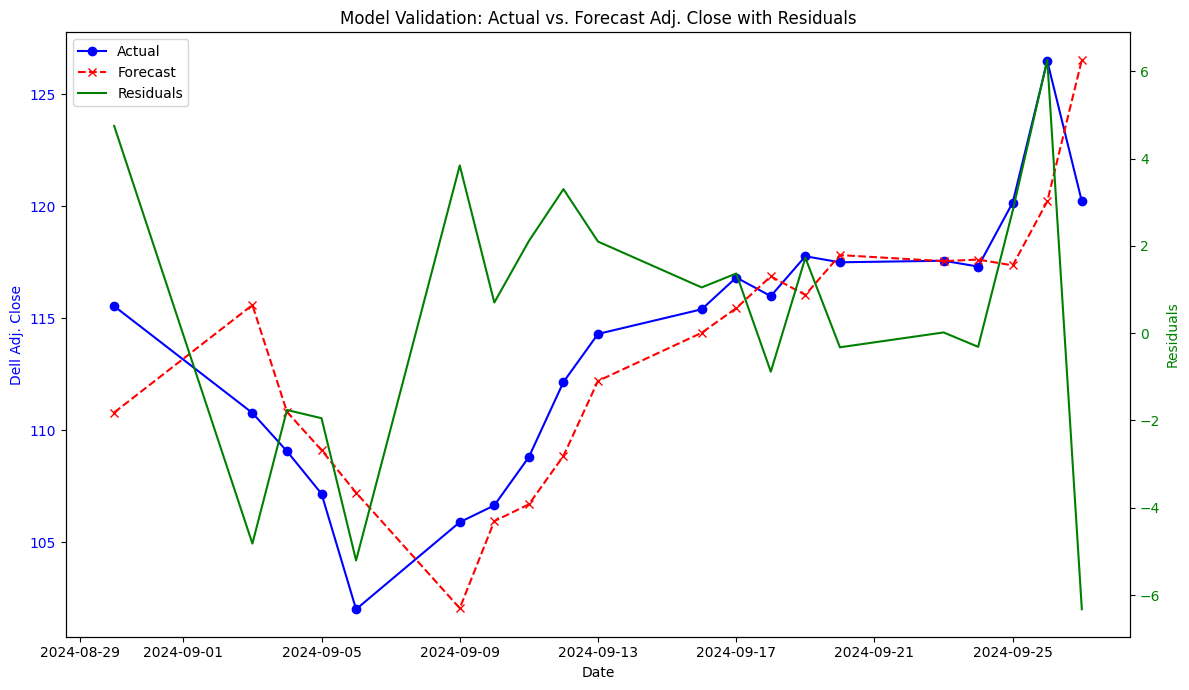

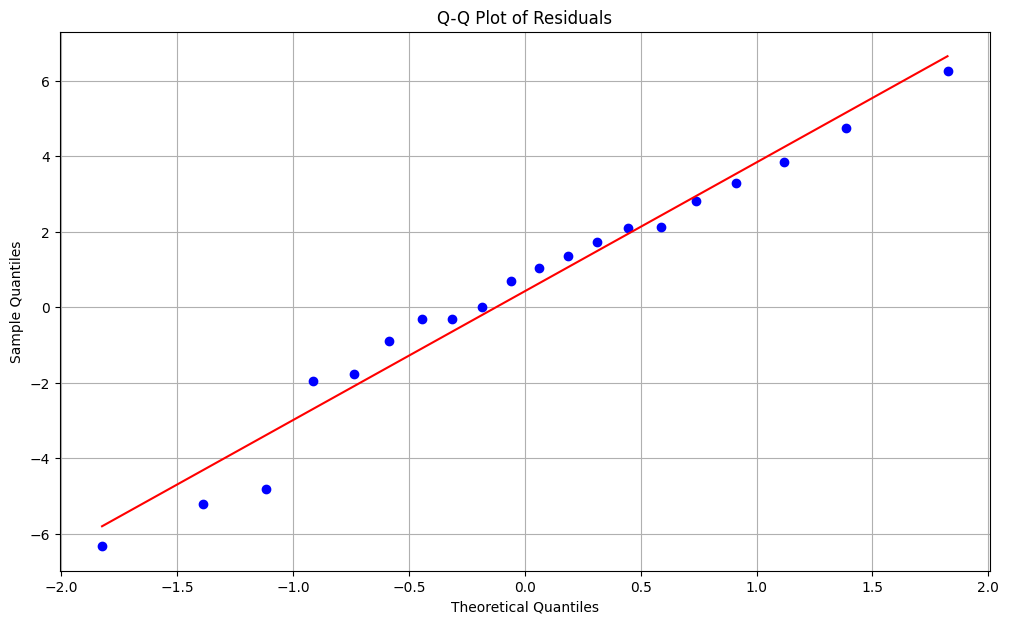

In [12]:
with open(f'{data_path}/config_part.json', 'r') as file:
    loaded_config_part = json.load(file)
print('Configuration loaded successfully:', loaded_config_part)

history = list(X)
validation = pd.read_csv(f'{data_path}/validation.csv', header=None, index_col=0, parse_dates=True)
y = validation.values.astype('float32')

predictions = []
yhat = float(loaded_model_fit.predict()[0])
predictions.append(yhat)
history.append(y[0])
print(f'>Predicted={yhat:.3f}, Expected={y[0][0]:.3f}')

for i in range(1, len(y)):
    t,d,s,p,b,r = loaded_config_part
    history = np.array(history)
    model = ExponentialSmoothing(history, trend=t, damped_trend=d, seasonal=s, seasonal_periods=p, use_boxcox=b)
    model_fit = model.fit(optimized=True, remove_bias=r)
    yhat = model_fit.predict(len(history), len(history))[0]
    predictions.append(yhat)
    history = list(history)
    history.append(y[i])
    print(f'>Predicted={yhat:.3f}, Expected={y[i][0]:.3f}')


predictions = np.reshape(np.array(predictions), (-1, 1)).ravel()
rmse = measure_rmse(y, predictions)
print(f'RMSE: {rmse:.3f}')

residuals = y.ravel() - predictions

# Create the figure for validation plot and residuals
fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.plot(validation.index, y, label='Actual', marker='o', color='blue')
ax1.plot(validation.index, predictions, color='red', linestyle='--', marker='x', label='Forecast')

ax1.set_xlabel('Date')
ax1.set_ylabel('Dell Adj. Close', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')


ax2 = ax1.twinx()
ax2.plot(validation.index, residuals, color='green', linestyle='-', label='Residuals')
ax2.set_ylabel('Residuals', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Model Validation: Actual vs. Forecast Adj. Close with Residuals')
fig.tight_layout()  

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()

# Q-Q Plot for Residuals
plt.figure(figsize=(12, 7))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True)
plt.show()

# Conclusion and further work

In this comprehensive project, we developed an Exponential Smoothing State Space (ETS) model to forecast Dell's stock price. We compared the performance of the ETS model against a naive model, which served as our baseline model. The ETS model achieved a Root Mean Square Error (RMSE) of 4.168, which is closely aligned with the performance of the naive model. The top five ETS models exhibited only marginal differences, with RMSE values ranging from 4.168 to 4.173. In contrast, the top five naive models displayed greater variability, with RMSE values spanning from 4.169 to 5.837.

Ultimately, we decided to proceed with the ETS model, reporting impressive performance using the out-of-sample validation dataset. The residuals of the model closely approximated a Gaussian distribution, as illustrated by the Q-Q plot. However, the overall performance of the ETS model did not meet our expectations for this dataset. As a result, future work could consider exploring other classical time-series models, such as SARIMA, or adapting advanced deep learning techniques like Convolutional Neural Networks (CNN) and Long Short-Term Memory (LSTM) networks.